In [ ]:
# Data Preprocessing and Visualization
# This notebook is designed to prepare floor plan data for Faster R-CNN or RetinaNet training.
# The main tasks include:
# 1. Standardizing images to a medium size (800x800).
# 2. Implementing several exploratory preprocessing methods, such as line thickening, random noise, grayscale and contrast enhancement.
# 3. Visualizing the effects of each preprocessing step on images and bounding boxes to ensure data quality.

#Size Options: 512*512, 800*800, 1024*1024

# ----------------- Module 0: Imports and Initialization -----------------

import json
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from collections import defaultdict

# Define file paths
IMAGES_DIR = Path('../data/raw/images')
COCO_FILE = Path('../data/interim/2.0-coco_annotations_cleaned.json')
VISUALIZATION_OUTPUT_DIR = Path('../reports/figures/preprocessing')

# Ensure the output directory exists
VISUALIZATION_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the COCO annotations
try:
    with open(COCO_FILE, 'r') as f:
        coco_data = json.load(f)
    print(f"Successfully loaded COCO annotation file from: {COCO_FILE}")
except FileNotFoundError:
    print(f"Error: COCO file not found at {COCO_FILE}. Please check the path.")
    # In a real notebook, you might stop here or load a dummy file
    coco_data = {'images': [], 'annotations': [], 'categories': []}

# Build convenient lookup structures
image_id_to_data = {img['id']: img for img in coco_data['images']}
annotations_by_image = defaultdict(list)
for ann in coco_data['annotations']:
    annotations_by_image[ann['image_id']].append(ann)
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
print("Data structures initialized.")


# Helper function to draw bounding boxes on an image
def draw_bboxes(ax, img, annotations, categories, color='red'):
    """Draws bounding boxes on a given axes."""
    for ann in annotations:
        x, y, w, h = ann['bbox']
        cat_id = ann['category_id']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # Add label
        ax.text(x, y-5, categories.get(cat_id, 'Unknown'), color='white', 
                fontsize=8, bbox=dict(facecolor=color, alpha=0.5))


Successfully loaded COCO annotation file from: ..\data\interim\2.0-coco_annotations_cleaned.json
Data structures initialized.


--- Module 1: Resizing and Padding ---
Visualizing 10 randomly sampled images...


C:\Users\WBJXYY\AppData\Local\Temp\ipykernel_5516\361979359.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


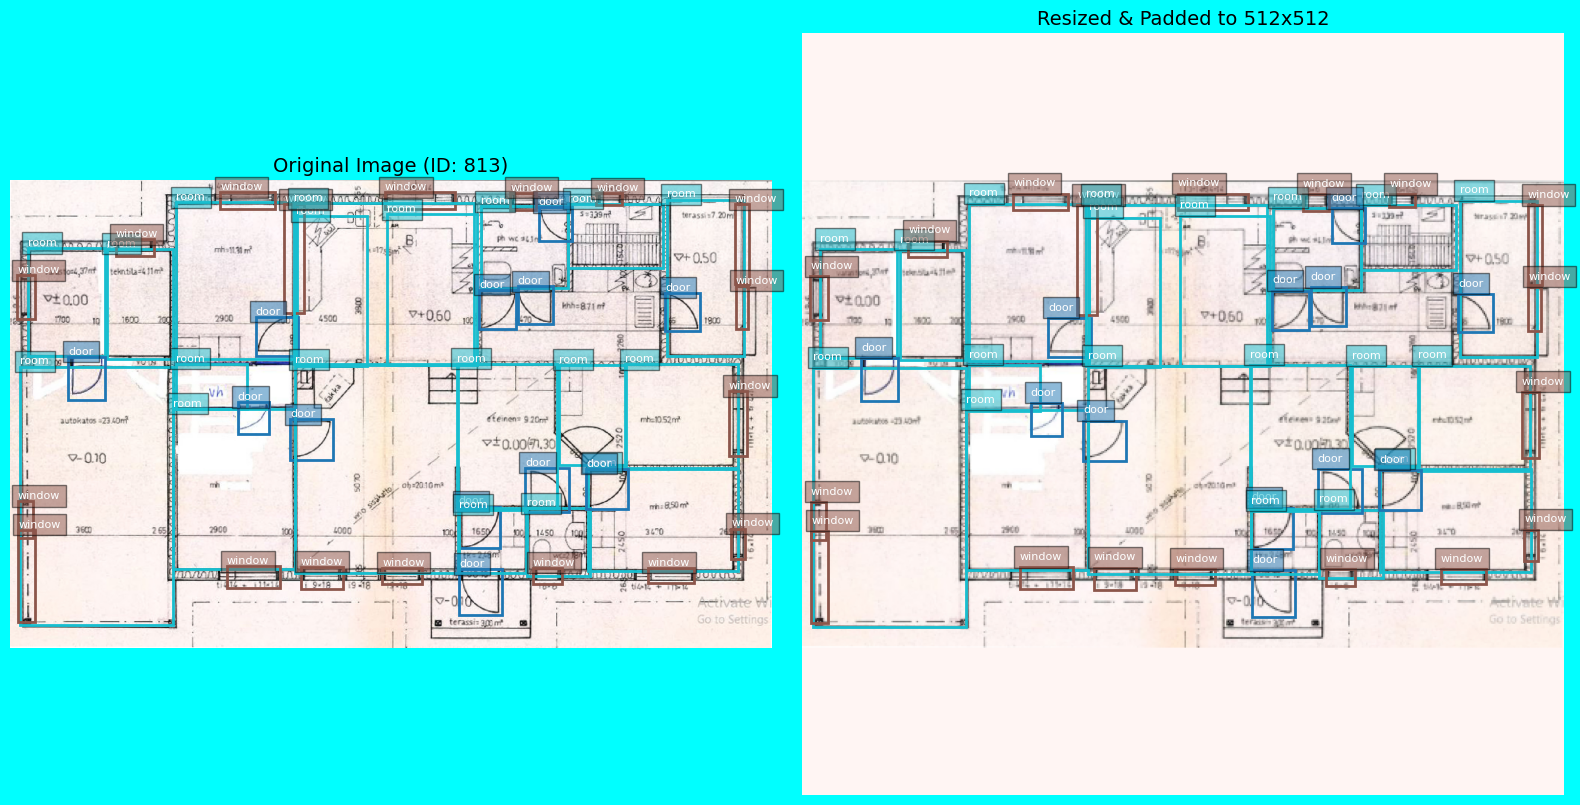

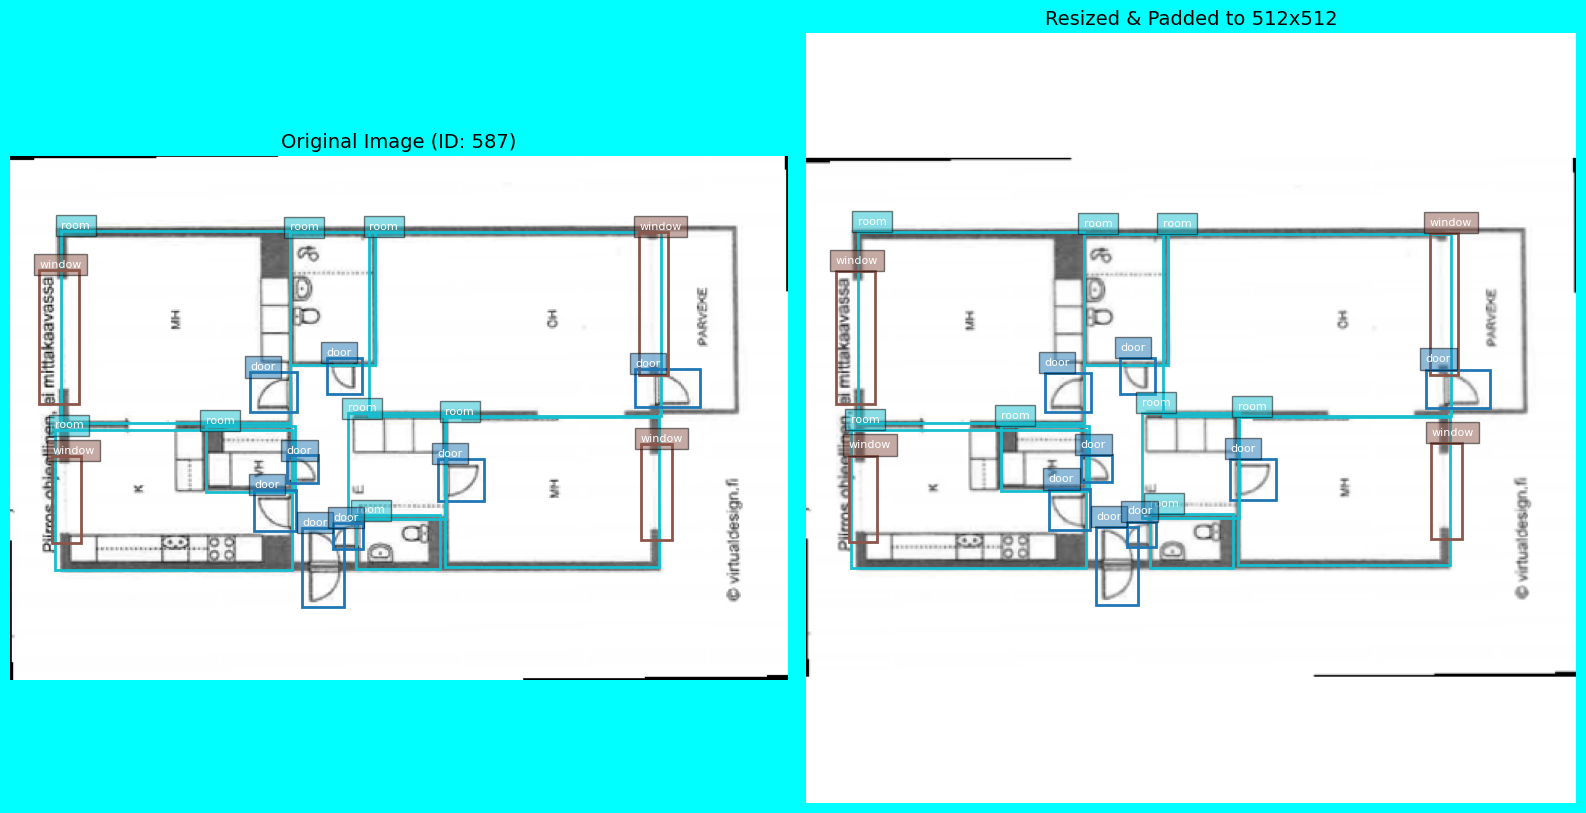

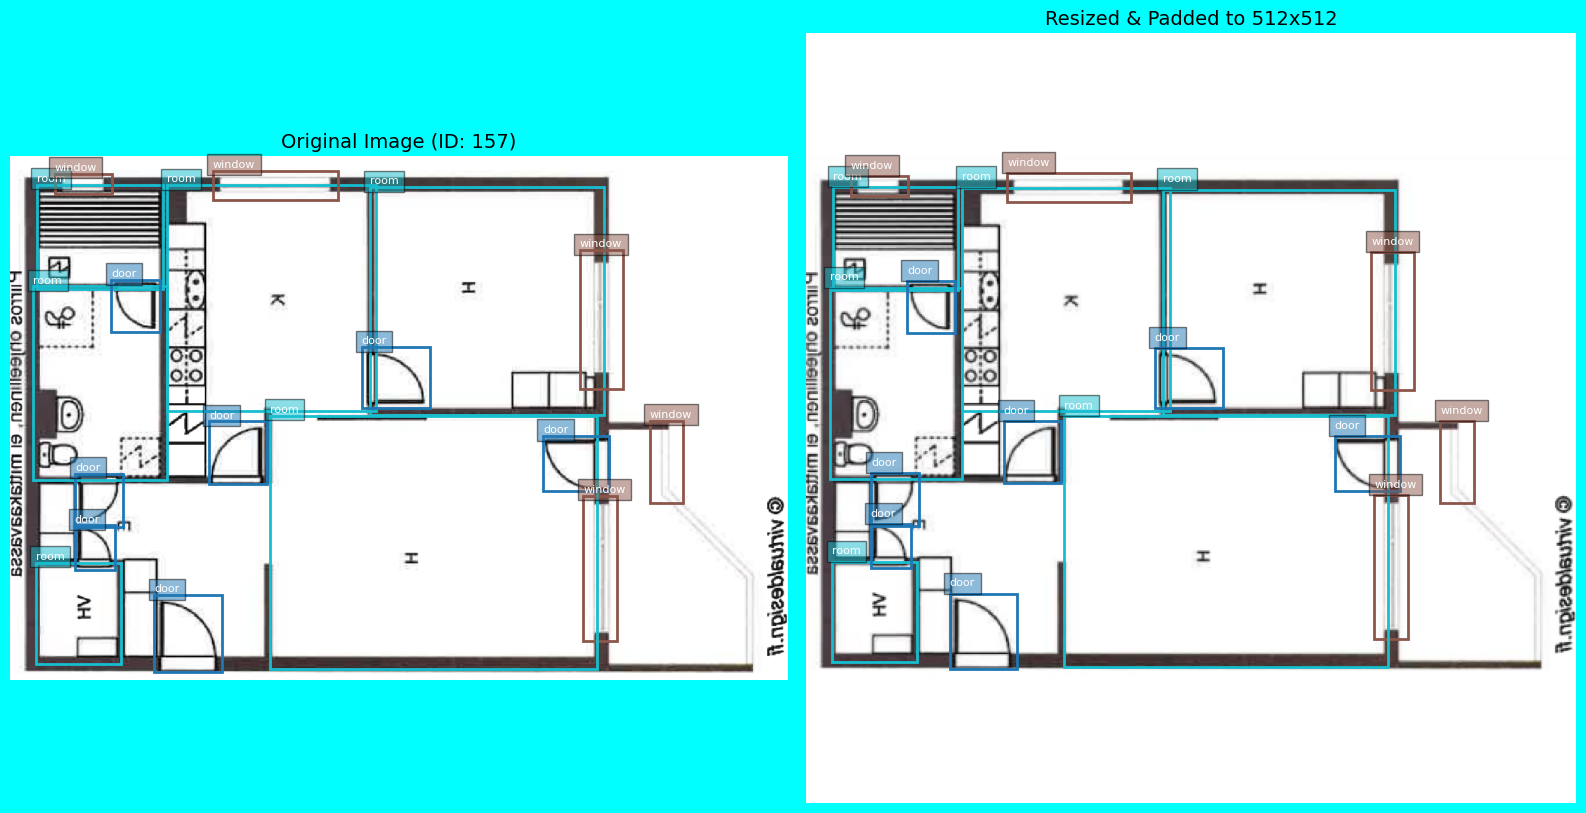

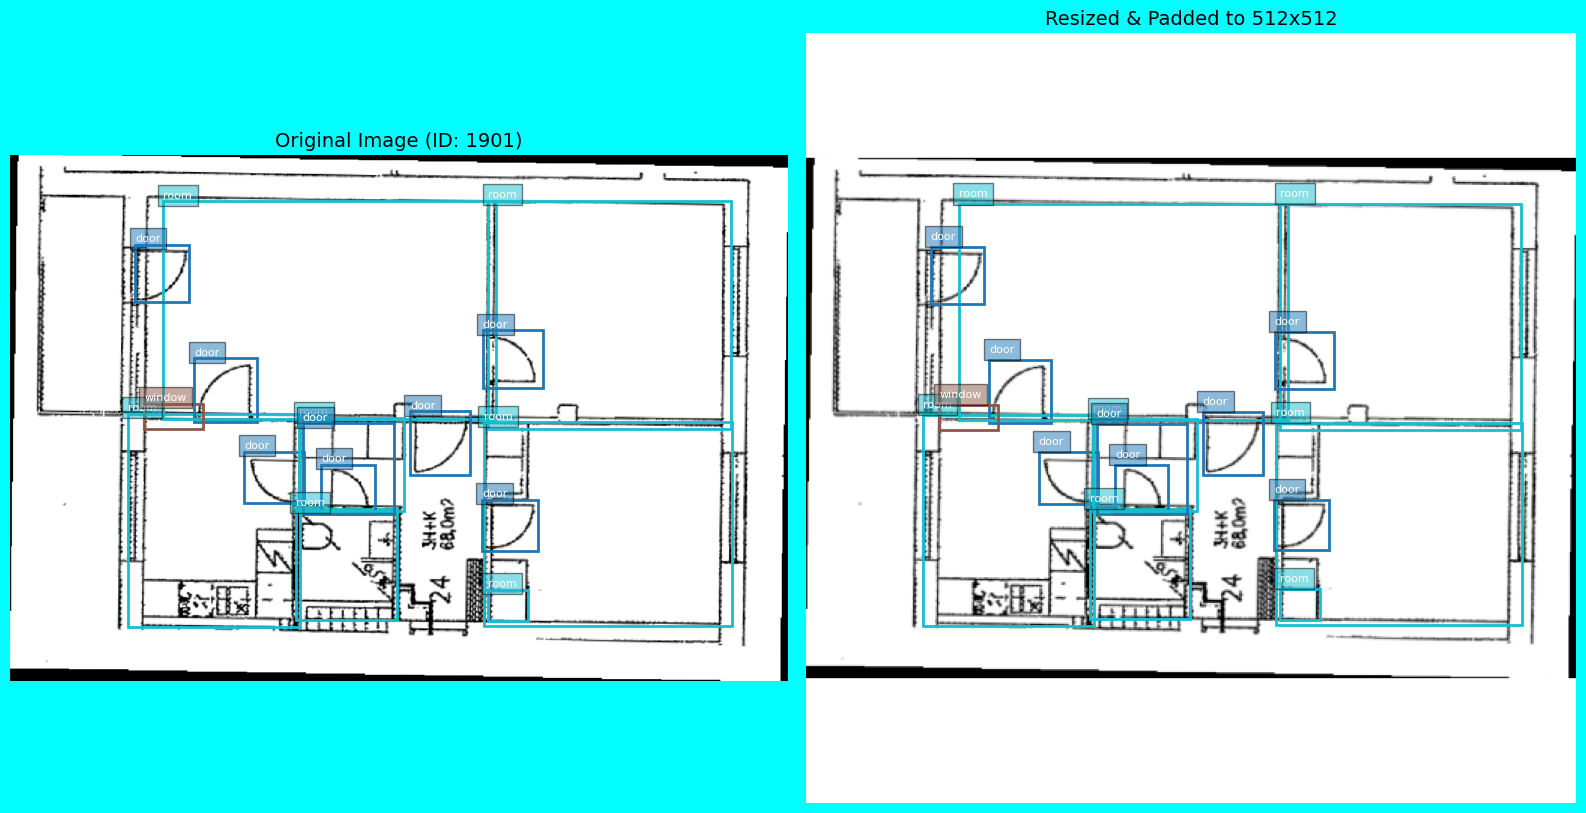

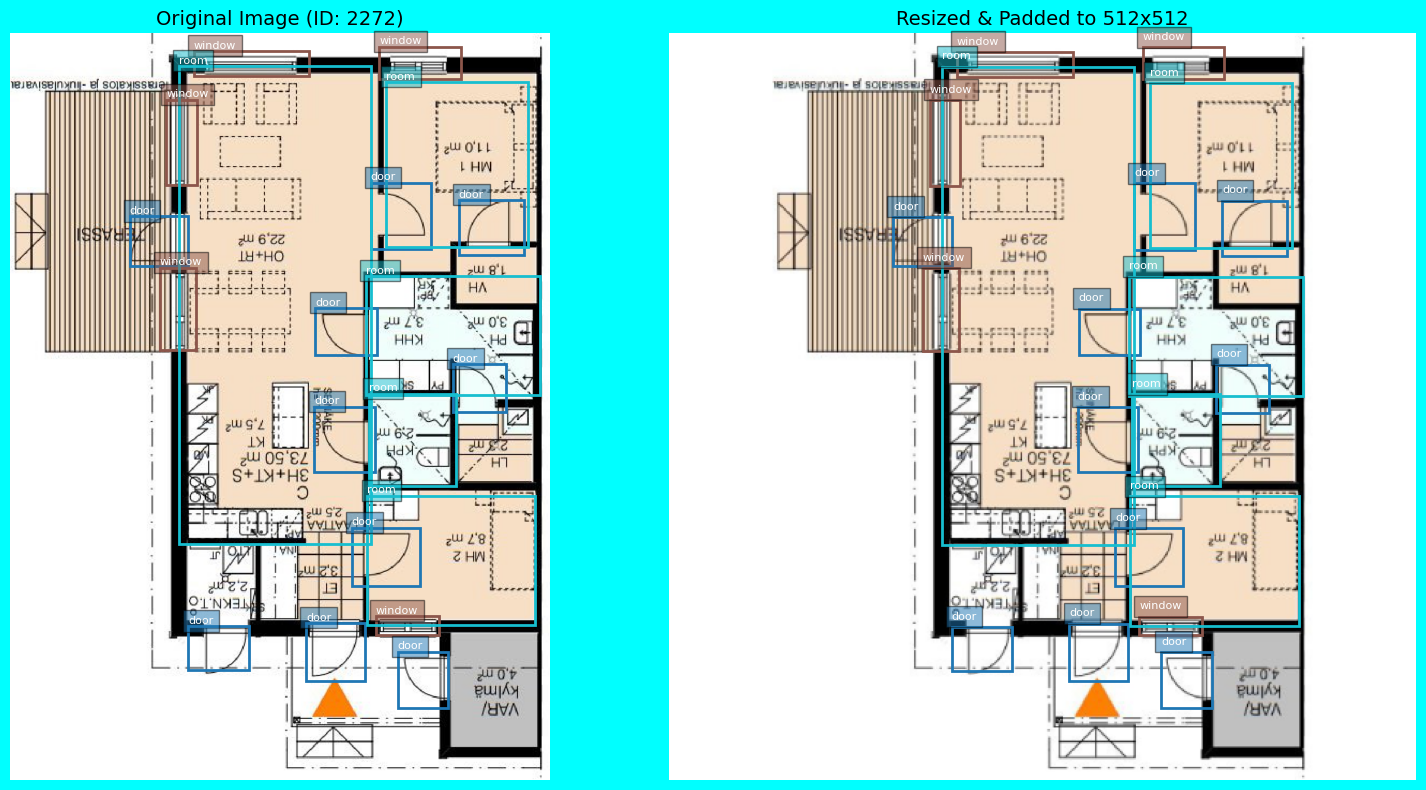

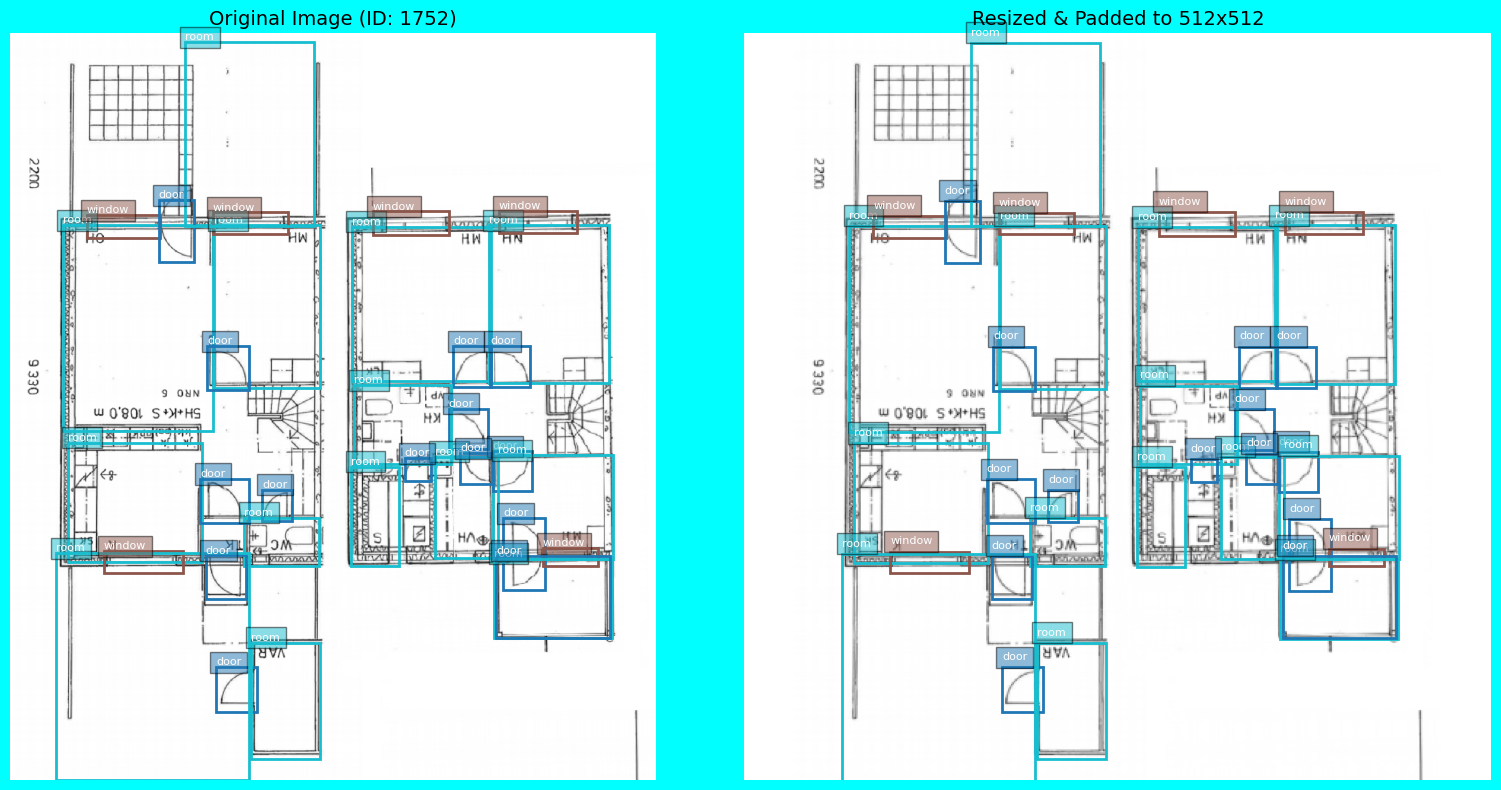

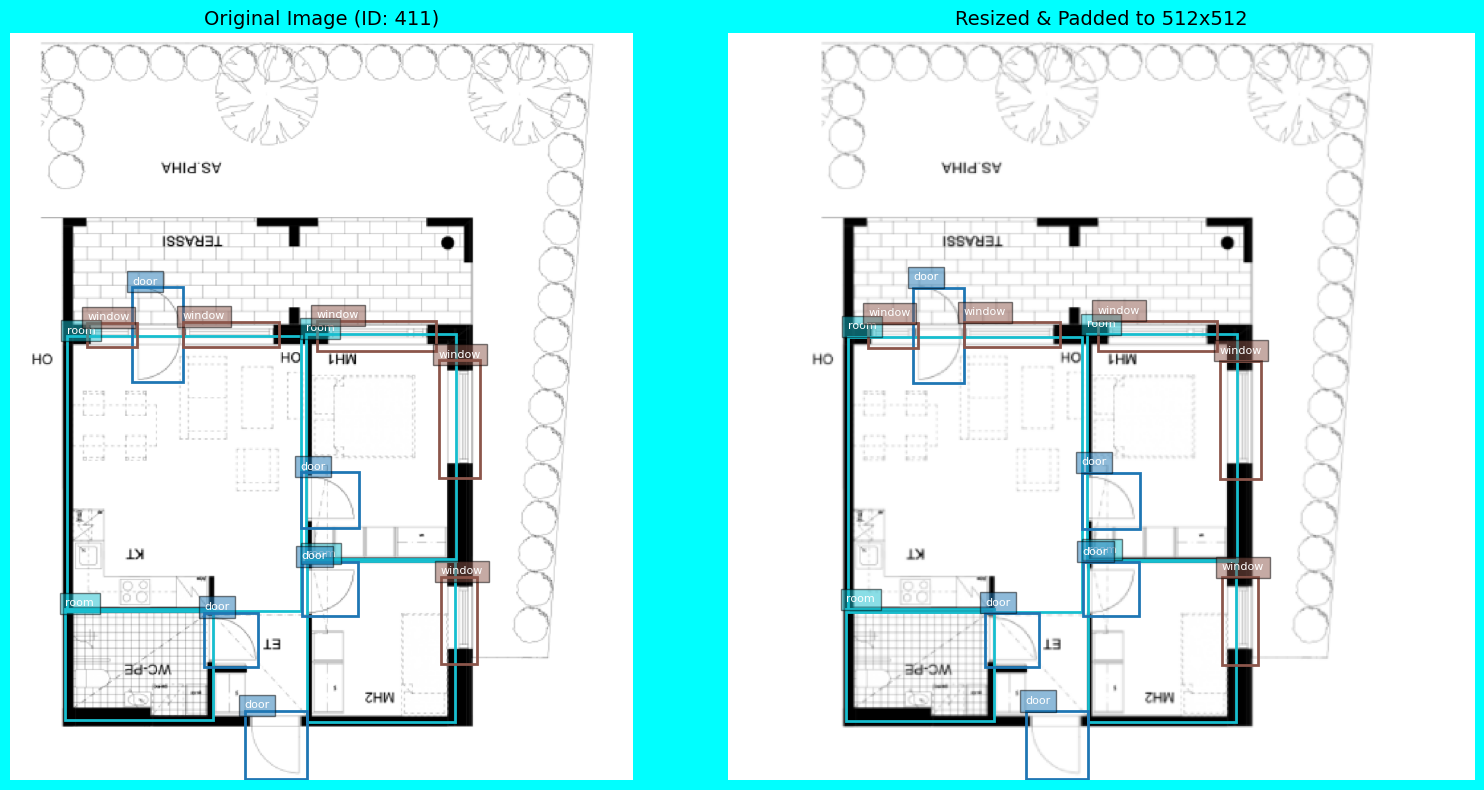

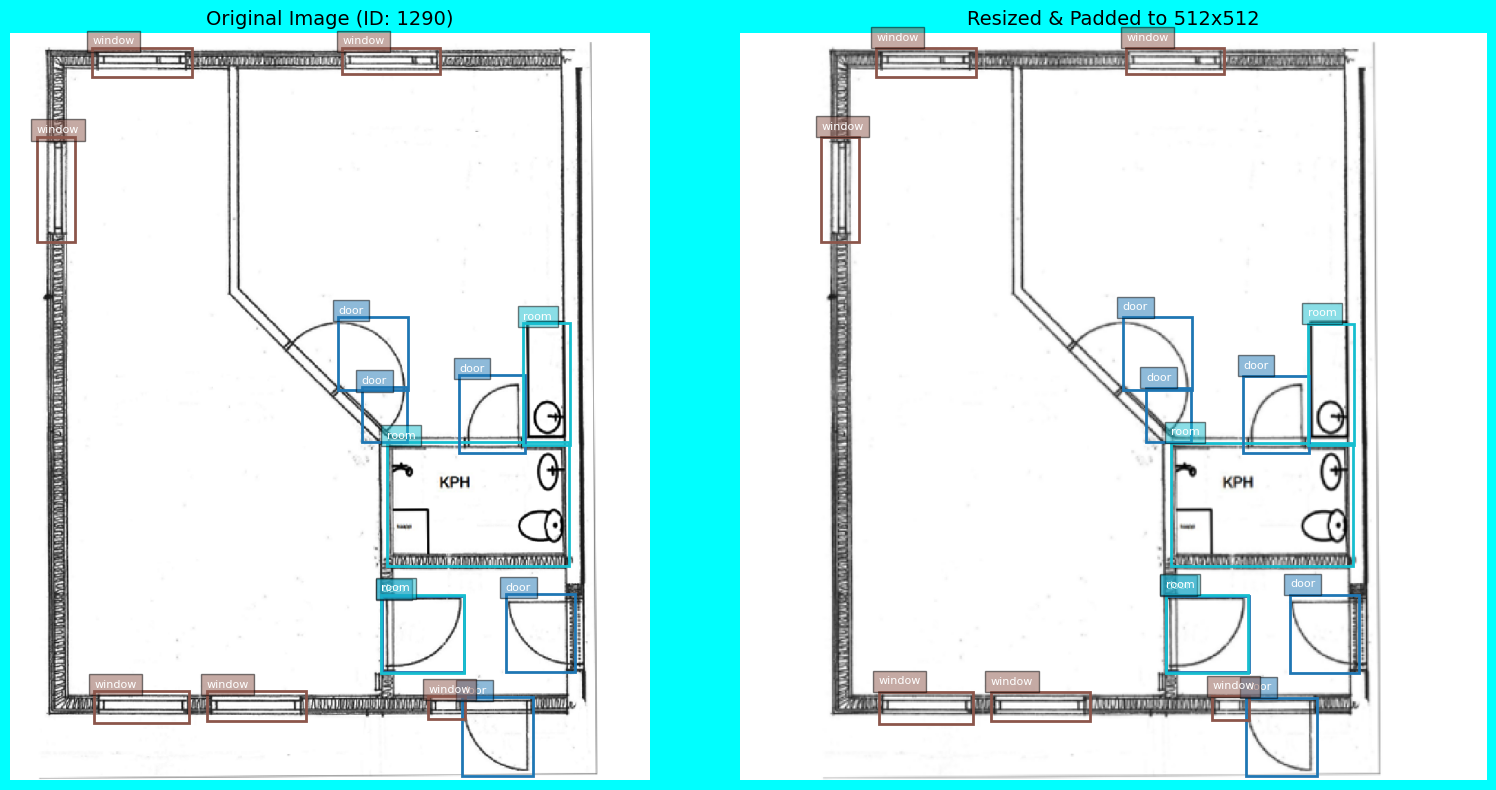

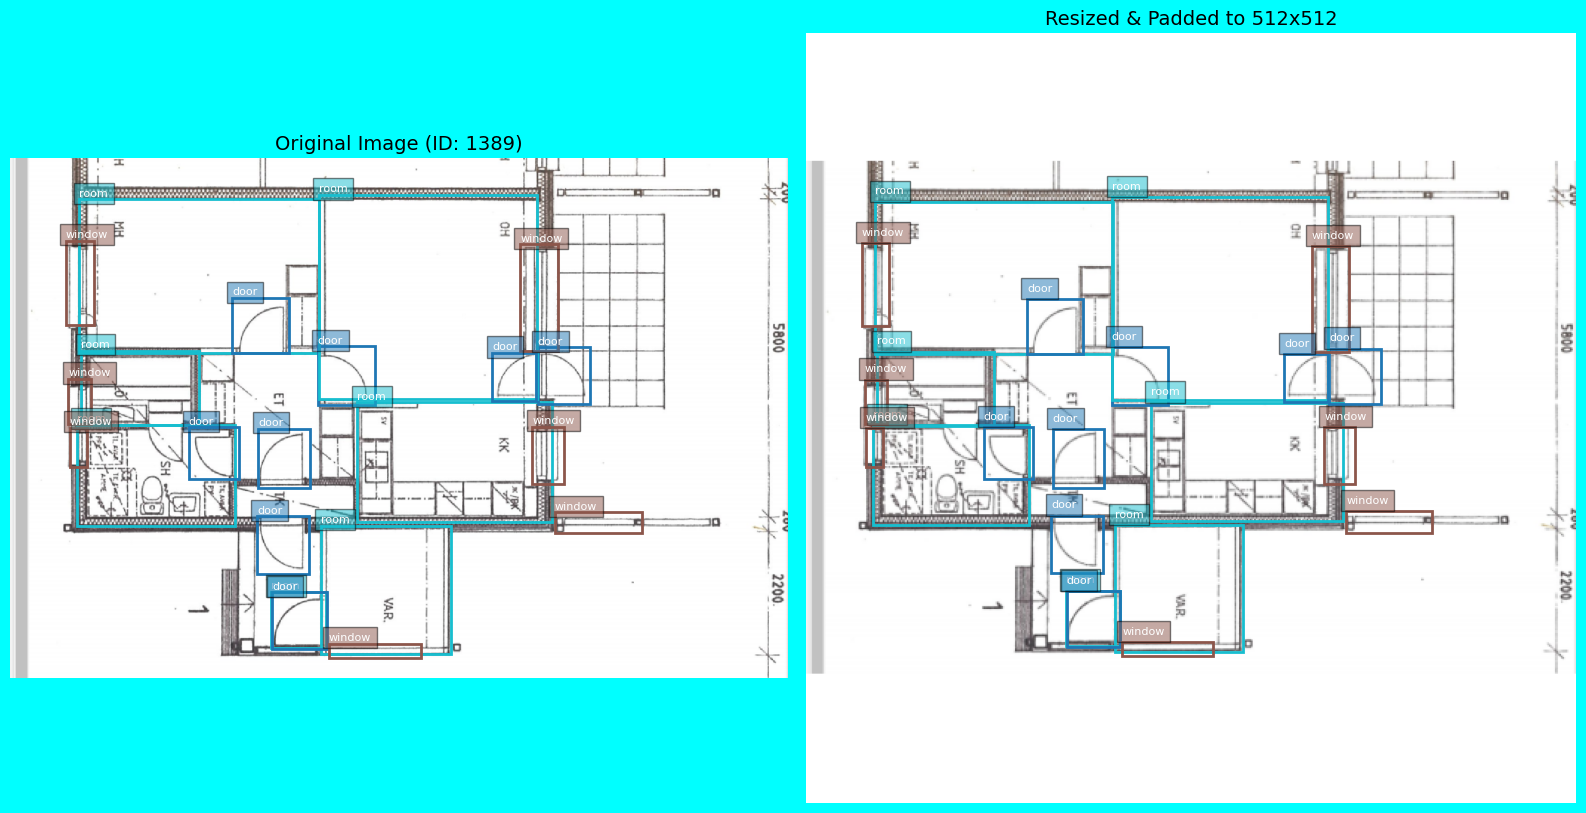

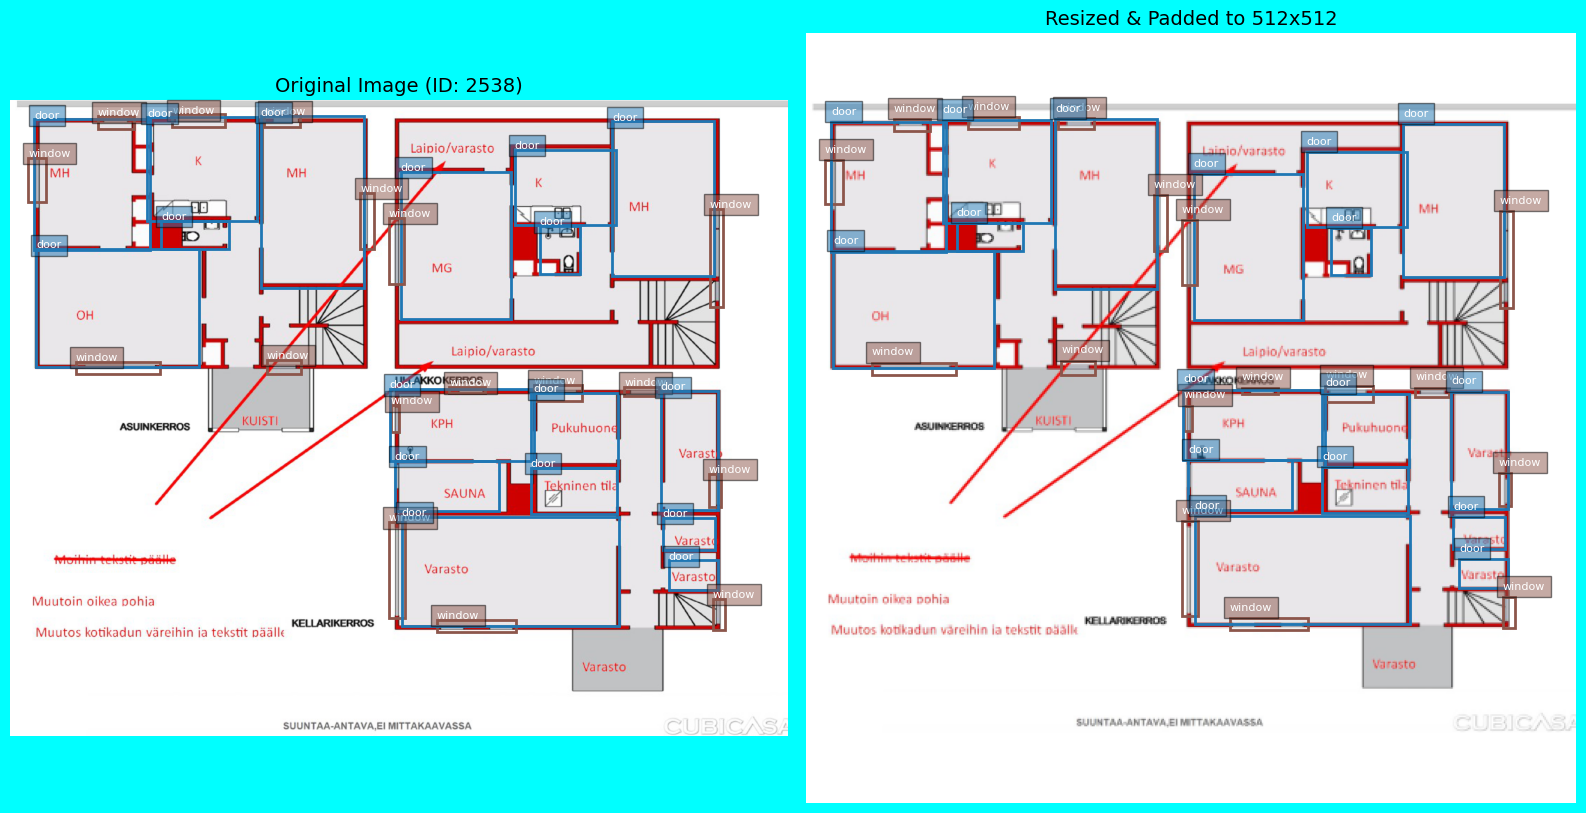

In [8]:
# ----------------- Module 1: Resize, Pad, and Visualize -----------------
# This block assumes all necessary imports and initial data loading are done.

# --- Helper function to draw bounding boxes ---
# This helper function MUST be defined once, before it's called.
def draw_bboxes(ax, annotations, categories, cat_colors):
    """Draws bounding boxes with category-specific colors."""
    for ann in annotations:
        x, y, w, h = ann['bbox']
        cat_id = ann['category_id']
        # Use the RGBA tuple directly for edgecolor
        # Provide a default color tuple in case cat_id is not in categories
        color = cat_colors.get(cat_id, (1, 0, 0, 1)) 
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        ax.text(x, y - 5, categories.get(cat_id, 'Unknown'), color='white', 
                fontsize=8, bbox=dict(facecolor=color, alpha=0.5))

def resize_and_pad(img: np.ndarray, target_size: int = 800):
    """
    Resizes an image and pads it to a square shape (target_size x target_size).
    Returns the resized and padded image, and the scale factor and padding info.
    """
    h, w = img.shape[:2]
    scale = min(target_size / w, target_size / h)
    
    new_w, new_h = int(w * scale), int(h * scale)
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    top, bottom = pad_h // 2, pad_h - (pad_h // 2)
    left, right = pad_w // 2, pad_w - (pad_w // 2)

    sample_pixels = img.reshape(-1, img.shape[-1])
    unique, counts = np.unique(sample_pixels, axis=0, return_counts=True)
    padding_color = unique[np.argmax(counts)]
    
    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color.tolist())
    
    return padded_img, scale, top, left

def transform_bboxes_for_resize(bboxes: list, scale: float, top_pad: int, left_pad: int):
    """
    Transforms a list of COCO format bboxes to match a resized and padded image.
    """
    transformed_bboxes = []
    for bbox in bboxes:
        x, y, w, h = bbox['bbox']
        
        x_new = x * scale
        y_new = y * scale
        w_new = w * scale
        h_new = h * scale
        
        x_new += left_pad
        y_new += top_pad
        
        new_bbox = [x_new, y_new, w_new, h_new]
        
        transformed_bbox = bbox.copy()
        transformed_bbox['bbox'] = new_bbox
        transformed_bboxes.append(transformed_bbox)
        
    return transformed_bboxes

def visualize_resizing(image_id, categories, target_size=800):
    """Visualizes the resizing and padding process with enhanced border visibility."""
    if image_id not in image_id_to_data:
        print(f"Image ID {image_id} not found.")
        return
        
    img_info = image_id_to_data[image_id]
    image_path = IMAGES_DIR / img_info['file_name']
    
    if not image_path.exists():
        print(f"Image file not found: {image_path}")
        return

    original_img = cv2.imread(str(image_path))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_annotations = annotations_by_image.get(image_id, [])

    padded_img, scale, top_pad, left_pad = resize_and_pad(original_img, target_size)
    padded_annotations = transform_bboxes_for_resize(original_annotations, scale, top_pad, left_pad)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor('cyan') 
    colors = plt.cm.get_cmap('tab10', len(categories))
    cat_colors = {cat_id: colors(i) for i, cat_id in enumerate(categories.keys())}
    
    # --- Plot original image ---
    ax1 = axes[0]
    ax1.imshow(original_img)
    ax1.set_title(f"Original Image (ID: {image_id})", fontsize=14)
    # Corrected: draw_bboxes no longer needs the image array
    draw_bboxes(ax1, original_annotations, categories, cat_colors)
    ax1.axis('off')
    ax1.set_facecolor('cyan') 
    ax1.patch.set_edgecolor('black')
    ax1.patch.set_linewidth(2)

    # --- Plot resized and padded image ---
    ax2 = axes[1]
    ax2.imshow(padded_img)
    ax2.set_title(f"Resized & Padded to {target_size}x{target_size}", fontsize=14)
    # Corrected: draw_bboxes no longer needs the image array
    draw_bboxes(ax2, padded_annotations, categories, cat_colors)
    ax2.axis('off')
    ax2.set_facecolor('cyan') 
    ax2.patch.set_edgecolor('black')
    ax2.patch.set_linewidth(2)

    plt.tight_layout()
    plt.show()

# --- Main execution for Module 1 ---
print("--- Module 1: Resizing and Padding ---")

if coco_data['images']:
    print("Visualizing 10 randomly sampled images...")
    image_ids_to_visualize = random.sample([img['id'] for img in coco_data['images']], 10)

    for image_id in image_ids_to_visualize:
        visualize_resizing(image_id, categories, target_size=512)  # Adjust target size as needed
else:
    print("No images to visualize.")


--- Module 2: Exploring Advanced Preprocessing ---


C:\Users\WBJXYY\AppData\Local\Temp\ipykernel_5516\1118692687.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


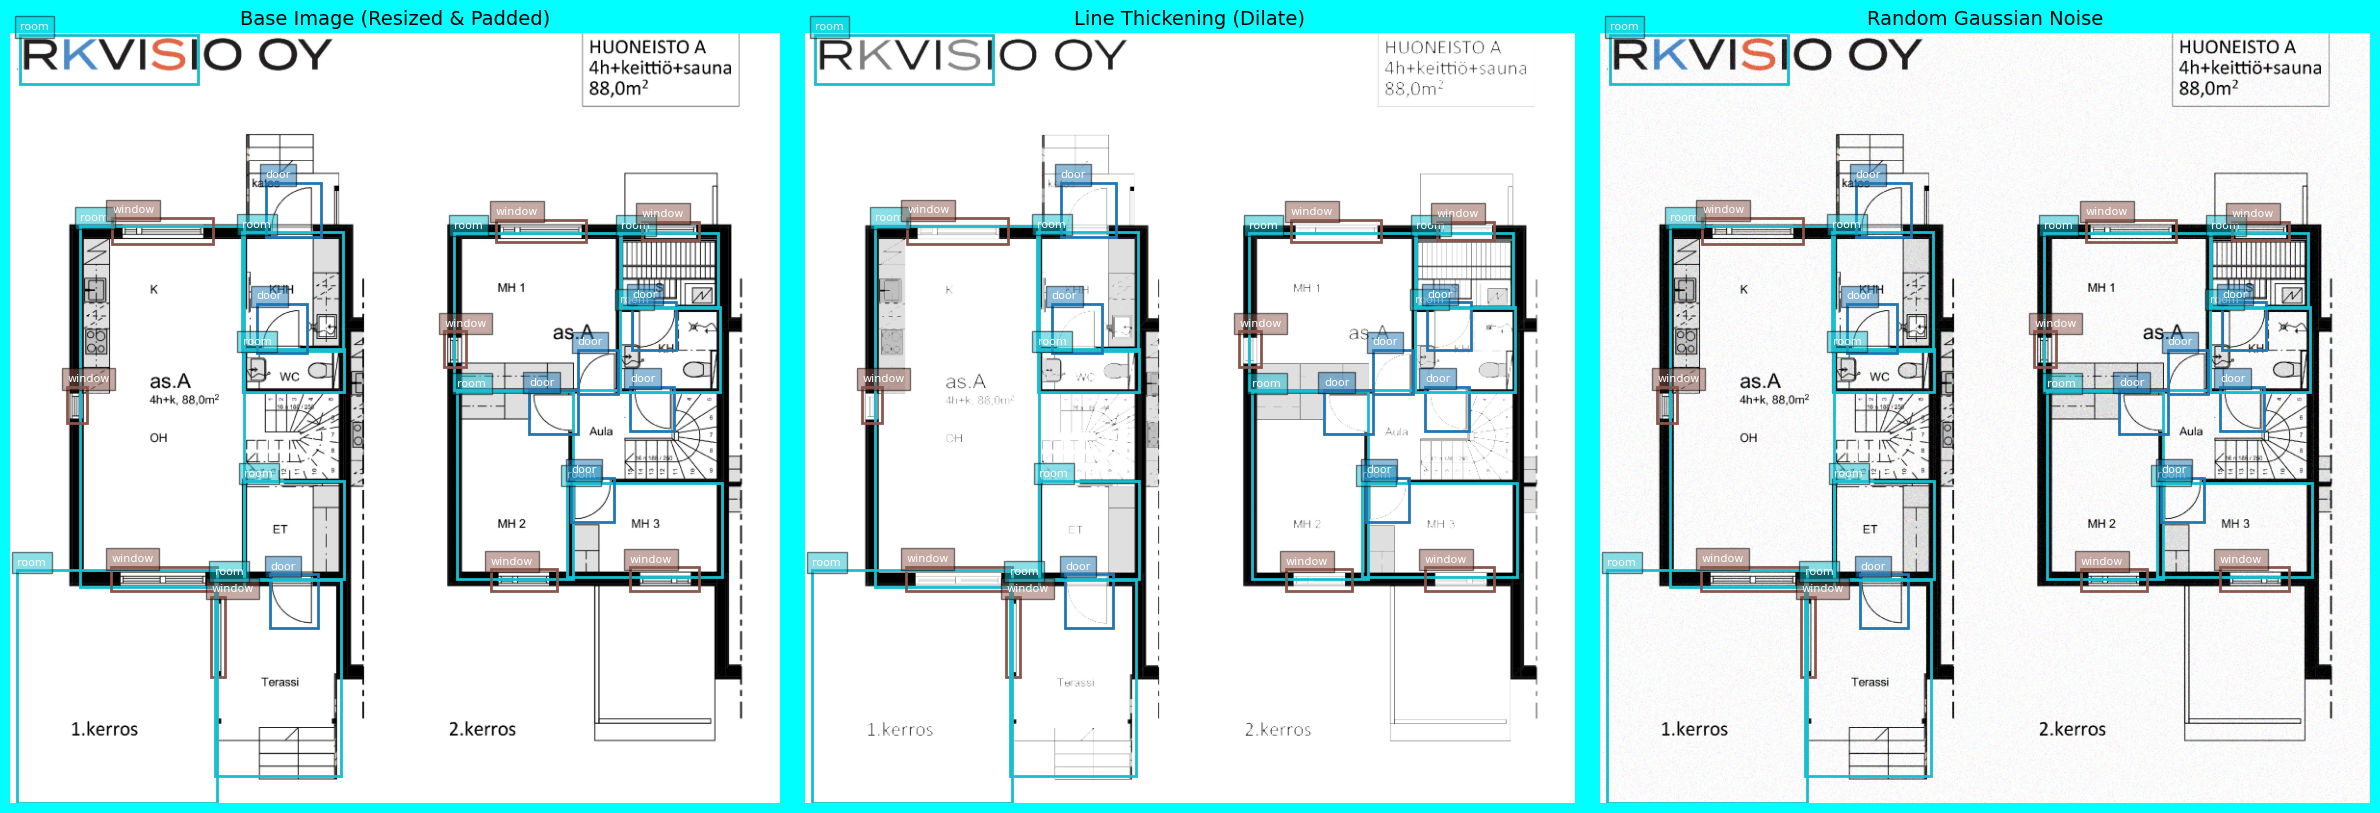

In [10]:
# ----------------- Module 2: Exploring Advanced Preprocessing (Corrected) -----------------
# This block assumes all necessary imports, initial data loading, and helper functions from Module 1 are defined.

def apply_line_thickening(img: np.ndarray, kernel_size: int = 2):
    """Thickens lines in a grayscale image using morphological dilation."""
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
    
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thickened_img = cv2.dilate(img_gray, kernel, iterations=1)
    
    # Convert back to RGB for visualization if needed
    if len(img.shape) == 3:
        thickened_img = cv2.cvtColor(thickened_img, cv2.COLOR_GRAY2RGB)
        
    return thickened_img

def add_random_noise(img: np.ndarray, mean: float = 0, std_dev: float = 10):
    """Adds random Gaussian noise to an image."""
    # Ensure noise is added to the correct data type
    img_float = img.astype(np.float32)
    noise = np.random.normal(mean, std_dev, img_float.shape).astype(np.float32)
    noisy_img_float = cv2.add(img_float, noise)
    noisy_img = np.clip(noisy_img_float, 0, 255).astype(np.uint8)
    return noisy_img
    
def visualize_advanced_preprocessing(image_id, categories, target_size=800):
    """Visualizes various advanced preprocessing techniques."""
    if image_id not in image_id_to_data:
        print(f"Image ID {image_id} not found.")
        return

    img_info = image_id_to_data[image_id]
    image_path = IMAGES_DIR / img_info['file_name']
    if not image_path.exists():
        print(f"Image file not found: {image_path}")
        return

    # Load original image, resize, and get bboxes
    original_img = cv2.imread(str(image_path))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    padded_img, scale, top_pad, left_pad = resize_and_pad(original_img, target_size)
    padded_annotations = transform_bboxes_for_resize(annotations_by_image.get(image_id, []), scale, top_pad, left_pad)

    # Apply preprocessing techniques
    thickened_img = apply_line_thickening(padded_img)
    noisy_img = add_random_noise(padded_img)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.patch.set_facecolor('cyan') 
    
    colors = plt.cm.get_cmap('tab10', len(categories))
    cat_colors = {cat_id: colors(i) for i, cat_id in enumerate(categories.keys())}
    
    # Plot resized base image
    ax1 = axes[0]
    ax1.imshow(padded_img)
    ax1.set_title(f"Base Image (Resized & Padded)", fontsize=14)
    draw_bboxes(ax1, padded_annotations, categories, cat_colors)
    ax1.axis('off')
    ax1.patch.set_edgecolor('black')
    ax1.patch.set_linewidth(2)
    
    # Plot thickened image
    ax2 = axes[1]
    ax2.imshow(thickened_img, cmap='gray' if len(padded_img.shape) == 2 or (len(padded_img.shape) == 3 and padded_img.shape[2] == 1) else None)
    ax2.set_title(f"Line Thickening (Dilate)", fontsize=14)
    draw_bboxes(ax2, padded_annotations, categories, cat_colors)
    ax2.axis('off')
    ax2.patch.set_edgecolor('black')
    ax2.patch.set_linewidth(2)
    
    # Plot noisy image
    ax3 = axes[2]
    ax3.imshow(noisy_img)
    ax3.set_title(f"Random Gaussian Noise", fontsize=14)
    draw_bboxes(ax3, padded_annotations, categories, cat_colors)
    ax3.axis('off')
    ax3.patch.set_edgecolor('black')
    ax3.patch.set_linewidth(2)

    plt.tight_layout()
    plt.show()

# --- Main execution for Module 2 ---
print("\n--- Module 2: Exploring Advanced Preprocessing ---")
if coco_data['images']:
    random_image_id = random.choice(coco_data['images'])['id']
    visualize_advanced_preprocessing(random_image_id, categories, target_size=800)
else:
    print("No images to visualize.")


--- Module 3: Grayscale and Contrast Enhancement (CLAHE) ---


C:\Users\WBJXYY\AppData\Local\Temp\ipykernel_5516\1162706646.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


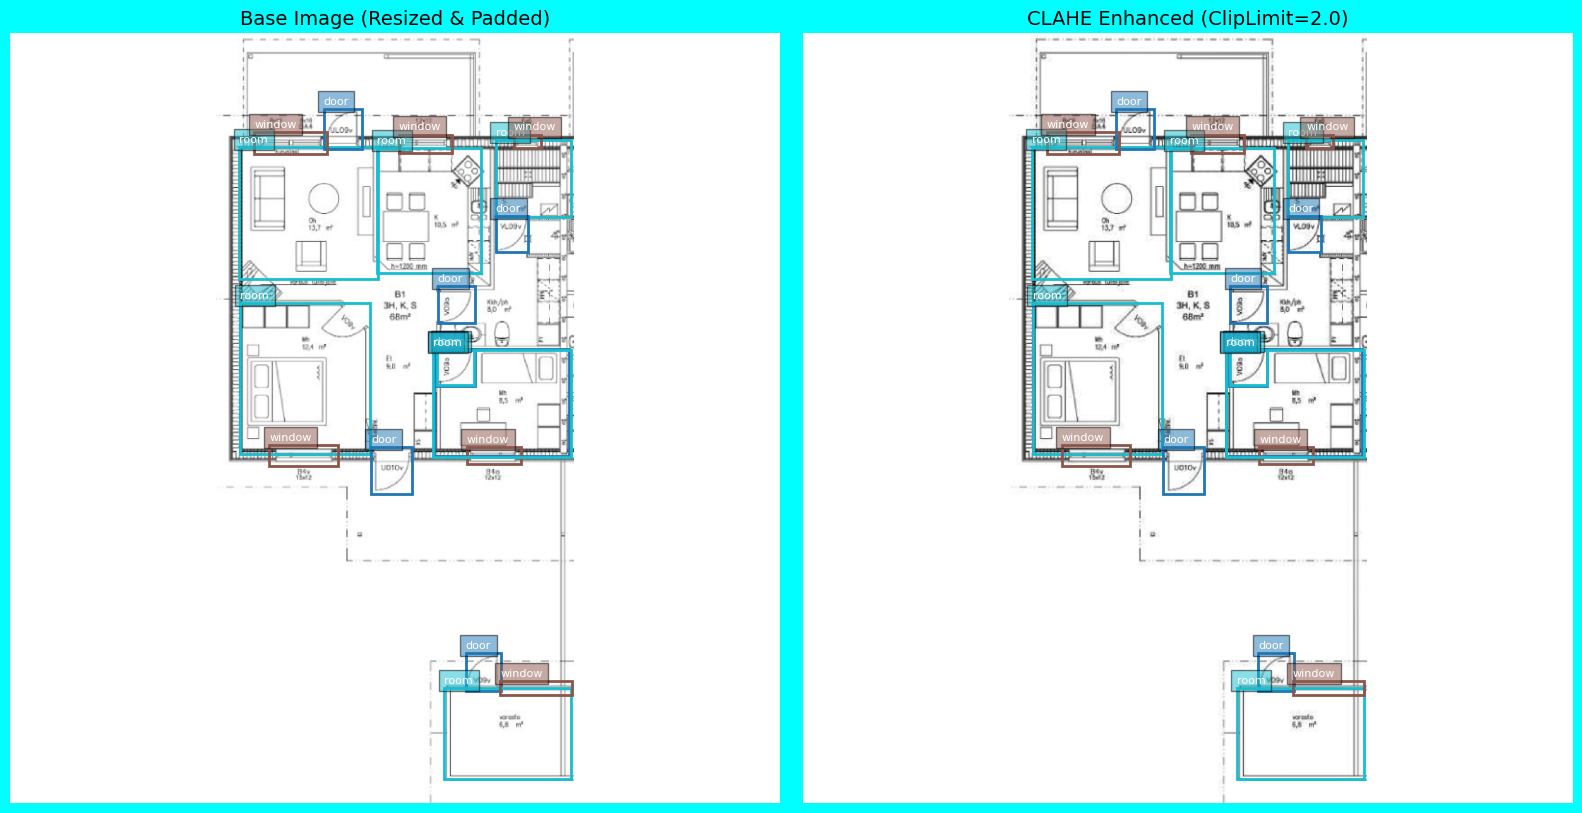

In [16]:
# ----------------- Module 3: Grayscale and Contrast Enhancement -----------------
# This block assumes all necessary imports, initial data loading, and helper functions from Module 1 are defined.

def convert_to_grayscale(img: np.ndarray):
    """
    Converts a color image to grayscale. If the image is already grayscale, it returns it as is.
    """
    if len(img.shape) == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def enhance_contrast_CLAHE(img: np.ndarray, clipLimit: float = 2.0, tileGridSize=(8, 8)):
    """
    Enhances the contrast of a grayscale image using CLAHE (Contrast Limited Adaptive Histogram Equalization).
    Args:
        img: The input image. Must be a single-channel grayscale image.
        clipLimit: The threshold for contrast limiting.
        tileGridSize: Size of grid for histogram equalization.
    Returns:
        The contrast-enhanced image.
    """
    # Ensure the image is a single channel for CLAHE
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
        
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    enhanced_img = clahe.apply(img_gray)
    
    # If the original was RGB, convert back to RGB for visualization compatibility
    if len(img.shape) == 3:
        enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
        
    return enhanced_img
    
def visualize_enhancements(image_id, categories, target_size=800):
    """
    Visualizes the effect of CLAHE-based contrast enhancement.
    """
    if image_id not in image_id_to_data:
        print(f"Image ID {image_id} not found.")
        return

    img_info = image_id_to_data[image_id]
    image_path = IMAGES_DIR / img_info['file_name']
    if not image_path.exists():
        print(f"Image file not found: {image_path}")
        return

    # Load original image, resize, and get bboxes
    original_img = cv2.imread(str(image_path))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    padded_img, scale, top_pad, left_pad = resize_and_pad(original_img, target_size)
    padded_annotations = transform_bboxes_for_resize(annotations_by_image.get(image_id, []), scale, top_pad, left_pad)

    # Apply the CLAHE enhancement
    # First, convert to grayscale, then apply CLAHE
    grayscale_img = convert_to_grayscale(padded_img)
    enhanced_img_clahe = enhance_contrast_CLAHE(grayscale_img)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor('cyan') 
    
    colors = plt.cm.get_cmap('tab10', len(categories))
    cat_colors = {cat_id: colors(i) for i, cat_id in enumerate(categories.keys())}
    
    # Plot resized base image
    ax1 = axes[0]
    ax1.imshow(padded_img)
    ax1.set_title(f"Base Image (Resized & Padded)", fontsize=14)
    draw_bboxes(ax1, padded_annotations, categories, cat_colors)
    ax1.axis('off')
    ax1.patch.set_edgecolor('black')
    ax1.patch.set_linewidth(2)
    
    # Plot the CLAHE enhanced image
    ax2 = axes[1]
    # imshow needs a colormap for single-channel images
    ax2.imshow(enhanced_img_clahe, cmap='gray')
    ax2.set_title(f"CLAHE Enhanced (ClipLimit=2.0)", fontsize=14)
    draw_bboxes(ax2, padded_annotations, categories, cat_colors)
    ax2.axis('off')
    ax2.patch.set_edgecolor('black')
    ax2.patch.set_linewidth(2)

    plt.tight_layout()
    plt.show()

# --- Main execution for Module 3 ---
print("\n--- Module 3: Grayscale and Contrast Enhancement (CLAHE) ---")
if coco_data['images']:
    random_image_id = random.choice(coco_data['images'])['id']
    visualize_enhancements(random_image_id, categories, target_size=800)
else:
    print("No images to visualize.")